### Noise regularised NNGPs on a toy 1d problem

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def create_toy_data(func, n=10, std=1., domain=[0., 1.]):
    x = np.linspace(domain[0], domain[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

def sinusoidal(x):
        return np.sin(2 * np.pi * x)

In [2]:
def relu_kernel(x, y, depth=2, weight_var=2.0, bias_var=0.01, mu_2=1.0):
    k_ab = weight_var*x*y + bias_var
    k_aa = weight_var*x*x*mu_2 + bias_var
    k_bb = weight_var*y*y*mu_2 + bias_var
    c_ab = k_ab/np.sqrt(k_aa*k_bb)
    c_aa = k_aa/np.sqrt(k_aa*k_aa)
    c_bb = k_bb/np.sqrt(k_bb*k_bb)
    theta_ab = np.arccos(c_ab)
    theta_aa = np.arccos(c_aa)
    theta_bb = np.arccos(c_bb)
    for _ in range(depth):
        k_ab = (weight_var/(2*np.pi))*np.sqrt(k_aa*k_bb)*(np.sin(theta_ab) + (np.pi - theta_ab)*np.cos(theta_ab)) + bias_var
        k_aa = (weight_var/(2*np.pi))*np.sqrt(k_aa*k_aa)*(np.sin(theta_aa) + (np.pi - theta_aa)*np.cos(theta_aa))*mu_2 + bias_var
        k_bb = (weight_var/(2*np.pi))*np.sqrt(k_bb*k_bb)*(np.sin(theta_bb) + (np.pi - theta_bb)*np.cos(theta_bb))*mu_2 + bias_var
        c_ab = np.round(k_ab/(np.sqrt(k_aa)*np.sqrt(k_bb)), 8)
        c_aa = np.round(k_aa/(np.sqrt(k_aa)*np.sqrt(k_aa)), 8)
        c_bb = np.round(k_bb/(np.sqrt(k_bb)*np.sqrt(k_bb)), 8)
        theta_ab = np.arccos(c_ab)
        theta_aa = np.arccos(c_aa)
        theta_bb = np.arccos(c_bb)
    return k_ab

### Samples from noisy NNGP prior as a function of the noise

In [256]:
import tensorflow as tf
import nngp
import gpr

num_points = 100
mu2 = 1.0
w = 2/mu2
x = np.linspace(-3, 3, num_points)
K1 = np.zeros((len(x), len(x)))
for i,x_i in enumerate(x):
    for j ,x_j in enumerate(x):
        K1[i,j] = relu_kernel(x_i, x_j, depth=20, weight_var=w, bias_var=0.001, mu_2=mu2)
        

mu2 = 1.5
w = 2/mu2
K2 = np.zeros((len(x), len(x)))
for i,x_i in enumerate(x):
    for j ,x_j in enumerate(x):
        K2[i,j] = relu_kernel(x_i, x_j, depth=20, weight_var=w, bias_var=0.001, mu_2=mu2)
    
mu2 = 10.0
w = 2/mu2
K3 = np.zeros((len(x), len(x)))
for i,x_i in enumerate(x):
    for j ,x_j in enumerate(x):
        K3[i,j] = relu_kernel(x_i, x_j, depth=20, weight_var=w, bias_var=0.001, mu_2=mu2)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


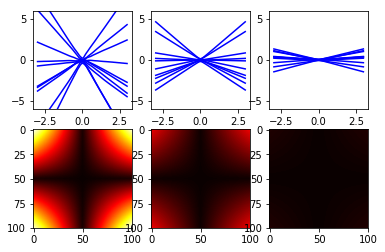

In [257]:
def normalize(x, kmin, kmax):
    return (x-kmin)/(kmax-kmin)

kernels = [K1, K2, K3]
k_max = np.max([np.max(x) for x in kernels])
k_min = np.min([np.min(x) for x in kernels])
normalized_kernels = [normalize(x, k_min, k_max) for x in kernels]
x = np.linspace(-3, 3, num_points)
num_samples = 10
count = 0
for K_n, K in zip(normalized_kernels, kernels):
    plt.subplot(2, 3, 1+count)
    for _ in range(num_samples):
        y = np.random.multivariate_normal(np.zeros((len(x),)), K)
        plt.plot(x, y, c='blue')
        plt.ylim(-6, 6)
    plt.subplot(2, 3, 4+count)
    plt.imshow(K_n, cmap='hot', vmin=0, vmax=1)
    count += 1
plt.show()

### Fitting GP to a set of training points

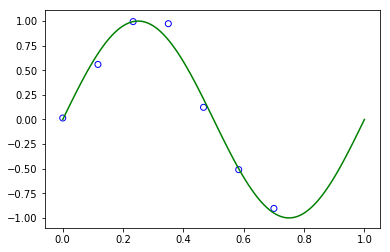

In [3]:
x_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain=[0., 0.7])
x = np.linspace(0, 1, 100)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.show()

In [195]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [196]:
x_train, y_train = create_toy_data(sinusoidal, n=4, std=0.1, domain=[0., 0.4])

In [229]:
def fit_nngps(n, end, d, mu2, sig_b, offset):
    
    x_train, y_train = create_toy_data(sinusoidal, n=n, std=0.1, domain=[0., end])

    N = len(x_train)
    x = np.linspace(0, 1, 100)

#d = 2
#mu2 = 1.0
#sig_b = 0.5
#offset = 0
    sig_w = 2/mu2 + offset

    # Compute kernel
    K = np.zeros((N, N))
    for i,x_i in enumerate(x_train):
        for j ,x_j in enumerate(x_train):
            K[i,j] = relu_kernel(x_i, x_j, depth=d, weight_var=sig_w, bias_var=sig_b, mu_2=mu2)
    
    plt.subplot(1, 3, 1)
    plt.imshow(K, cmap='hot', vmin=0, vmax=0.8)
    
    # samples from the prior
    plt.subplot(1, 3, 2)
    for _ in range(10):
        y = np.random.multivariate_normal(np.zeros((len(x_train),)), K)
        plt.plot(x_train, y, c='blue')
    
    noise_var = 0.01
    covariance = K + noise_var*np.ones((N, N))
    inv_cov = np.linalg.inv(covariance)
    t = y_train + noise_var

    # make predictions
    k = np.zeros((N,))
    y = np.zeros(len(x))
    y_std = np.zeros(len(x))
    for i, p in enumerate(x):
        c = relu_kernel(p, p, depth=d, weight_var=sig_w, bias_var=sig_b, mu_2=mu2)
        for j, x_t in enumerate(x_train):
            k[j] = relu_kernel(p, x_t, depth=d, weight_var=sig_w, bias_var=sig_b, mu_2=mu2)
        y[i] = np.dot(np.transpose(k), inv_cov).dot(t)
        y_std[i] = np.sqrt(c - np.transpose(k).dot(inv_cov).dot(k))
    
    
    plt.subplot(1, 3, 3)
    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
    plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
    plt.plot(x, y, color="r", label="gpr")
    plt.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")
    plt.show()

In [230]:
interact(fit_nngps, n=(1,10), end=(0.1, 1.0), d=(2, 20), mu2=(1.0, 2.0), sig_b=(0.0001, 10), offset=(-2.0, 2.0));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT01LCBkZXNjcmlwdGlvbj11J24nLCBtYXg9MTAsIG1pbj0xKSwgRmxvYXRTbGlkZXIodmFsdWU9MC41NSwgZGVzY3JpcHRpb27igKY=
